# Applying Data Science to CU's Course Schedule
## Nick Spooner

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import math

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


The dataset comes from a spreadsheet provided by CU Boulder describing all courses offered at the school from Fall 2020 to Fall 2021. Columns in the table describe course identifiers, instructor names, course ratings, and some other information.

In [2]:
df=pd.read_csv('classes.csv', encoding='latin-1')
df.head(6)

,Term,Year,Campus,College,Dept,Sbjct,Crse,Sect,Crse Title,Instructor Name,...,Synth,Diverse,Respect,Challenge,Creative,Discuss,Feedback,Grading,Questions,Tech
0,Fall,2020,B3,EDUC,EDUC,EDUA,5000,100,History and Policy for CLD,"Flores, Rebecca",...,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0
1,Fall,2020,B3,EDUC,EDUC,EDUA,5004,100,The Teacher in SEL,"Stamatis, Kristina Marie",...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN
2,Fall,2020,B3,EDUC,EDUC,EDUA,5015,100,Vision Equitable Sci Tchg Lrng,"Wingert, Kerri",...,4.5,4.5,5.0,5.0,4.5,5.0,5.0,5.0,5.0,5.0
3,Fall,2020,B3,EDUC,EDUC,EDUA,5019,100,Compassion and Dignity for EDU,"Stamatis, Kristina Marie",...,4.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0
4,Fall,2020,B3,ENGR,ECEN,ECEA,5315,100,Real-Time Emb Sys Concp Pract,"Siewert, Samuel Burk",...,3.0,3.5,2.5,3.5,2.5,3.0,2.0,3.0,2.0,4.0
5,Fall,2020,B3,ENGR,ECEN,ECEA,5315,200,Real-Time Emb Sys Concp Pract,"Siewert, Samuel Burk",...,4.5,4.0,3.0,4.5,4.5,4.0,4.0,4.5,4.0,4.5


We're interested in using this data to group the courses by similarity. The first method we'll perform on this data is the k-means algorithm so that we can cluster the courses into similar groups and visually analyze the data. To start, we'll drop all duplicate course titles. Let's see why this step is necessary by counting the number of classes in the file, and then counting how many have a unique course title.

Because each course is offered multiple times a day, there are many duplicates in our table. Let's drop each of the duplicates and just pick one session of each course for our sample.

In [3]:
df = df.drop(df[df['Crse Lvl'] == 'Graduate'].index)
df = df.drop_duplicates(subset = ['Term', 'Year', 'Crse Title', 'Instructor Name'])
df = df.drop(df[df.Enroll > 700].index)

print(f"Total number of unique undergrad courses: {df.shape[0]}")

Total number of unique undergrad courses: 12449


Now we have the necessary dataset. We now construct a distance function and prepare a subset of the data to run the k-means algorithm on. Each of the columns plugged into the algorithm will determine how similar a class is to each of the centroids. Columns like department, college, instructor, and mean rating score will be necessary here. Since a mean rating score isn't actually provided, we'll have to calculate that from all rating columns in the dataset for each row.

In [4]:
mean_ratings = df.iloc[:, -16:].mean(axis = 1, skipna = True)
mean_ratings = np.nan_to_num(mean_ratings, nan=2.5)

In [158]:
titles = df['Crse Title'].unique()
title_nums = {titles[i]: i for i in range(len(titles))}
titles_by_num = [title_nums[x] for x in df['Crse Title']]

instructors = df['Instructor Name'].unique()
instructor_nums = {instructors[i]: i for i in range(len(instructors))}
instructors_by_num = [instructor_nums[x] for x in df['Instructor Name']]

colleges = df['College'].unique()
college_nums = {colleges[i]: i for i in range(len(colleges))}
colleges_by_num = [college_nums[x] for x in df.College]

depts = df['Dept'].unique()
dept_nums = {depts[i]: i for i in range(len(depts))}
depts_by_num = [dept_nums[x] for x in df.Dept]

responses = [float(x.strip('%'))/100 for x in df['Resp Rate']]

In [146]:
unnormalized_classes = pd.DataFrame(zip(titles_by_num, colleges_by_num, depts_by_num, instructors_by_num, df['Enroll'], responses, mean_ratings),
columns=['Class', 'College', 'Dept', 'Instructor', '# Enrolled', 'Response %', 'Mean Ratings'])

We now normalize the data to help compute the PCA and k-means algorithms.

In [7]:
normalized = []
for col in unnormalized_classes:
    normalized.append(unnormalized_classes[col] / np.mean(unnormalized_classes[col]))

classes = pd.DataFrame(normalized).T

Here we run PCA to determine the 3 principal dimensions from the top 3 eigenvectors. This code was mostly borrowed from Notebook 19 PCA Solutions.

In [8]:
M = np.array(classes).T

MTM = np.matmul(np.transpose(M), M)
# print(MTM)

evals, evecs = np.linalg.eig(MTM)
# print(evals)
# print(evecs)

evals_sorted = evals_sorted = np.flip(np.sort(evals),0)
idx_sorted = [list(evals).index(ee) for ee in evals_sorted]
E = evecs[:,idx_sorted]
# print(E)

ME3 = np.matmul(M, E[:,:3])

pd.DataFrame(abs(ME3), columns=['PC-1', 'PC-2', 'PC-3'], index=classes.columns)

,PC-1,PC-2,PC-3
Class,121.369395,29.046002,5.361726
College,132.953581,41.298715,50.111933
Dept,127.005664,31.466513,26.146054
Instructor,117.760384,21.101431,14.623462
# Enrolled,131.537686,132.843217,11.705670
Response %,104.854960,11.429484,54.040022
Mean Ratings,103.036602,7.550770,33.811446


We see that College, # Enrolled, and Response % are the top three dimensions. Let's compute our dimension-reduced matrix.

In [9]:
Einv = np.linalg.inv(E)
for k in range(1,4):
    Ek = E.copy()
    Ek[:,k:] = np.zeros((M.shape[1], M.shape[1]-k))
    MEk = np.matmul(M,Ek)
    Mk = np.matmul(MEk, Einv)

result = pd.DataFrame(np.real(Mk), index=classes.columns).T

We can plot the three dimensions against each other to see how the data looks before any clustering.

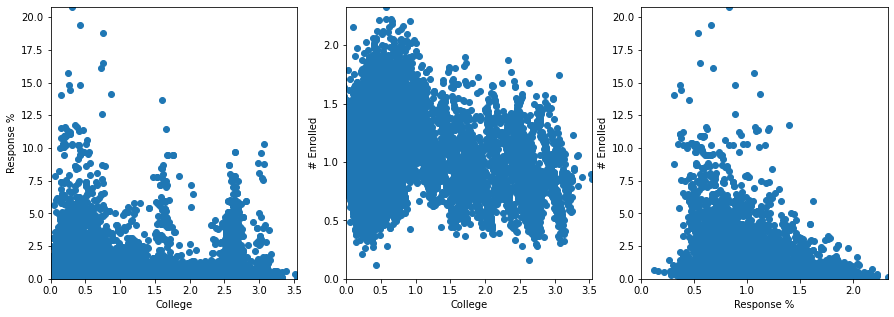

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
ax1.scatter([x for x in result['College']], [y for y in result['# Enrolled']])
ax1.axis([0, max(result['College']), 0, max(result['# Enrolled'])])

ax2.scatter([x for x in result['College']], [y for y in result['Response %']])
ax2.axis([0, max(result['College']), 0, max(result['Response %'])])

ax3.scatter([x for x in result['Response %']], [y for y in result['# Enrolled']])
ax3.axis([0, max(result['Response %']), 0, max(result['# Enrolled'])])

ax1.set(xlabel='College', ylabel='Response %')
ax2.set(xlabel='College', ylabel='# Enrolled')
ax3.set(xlabel='Response %', ylabel='# Enrolled')

plt.show()

Now let's setup the k-means algorithm and run our matrix through it. This code was borrowed from the Homework 3 Solutions notebook.

In [11]:
def distance(d1, d2):
    return np.sqrt(np.sum((d1-d2)**2))


def kmeans(df, k=4, tol=0.05):
    clocs=np.random.choice(range(len(df)), size=k)
    centroids = np.array([df.iloc[clocs[ki]] for ki in range(k)])
    
    dists=np.zeros((k,len(df)))
    clusters = np.array([-1]*len(df))
    
    ii=0
    Done=False
    while not Done:
        #convergence checks
        centroidso=centroids.copy()
        ii+=1
        if ii==50: 
            Done==True
            print('No convergence in 50 steps')
        for ji in range(k):
            dists[ji,:]=df.apply(lambda x: distance(x, centroids[ji]), axis=1)
        clusters=dists.argmin(axis=0)
        for ji in range(k):
            centroids[ji,:]=np.sum(df.loc[clusters==ji])/np.sum(clusters==ji)
        
        if distance(centroids, centroidso)<tol: 
            Done=True
    meanerror=np.sum(dists.min(axis=0)**2)/len(df)
    return centroids, clusters, meanerror

The result matrix containing the dimension-reduced data is now passed into the k-means function. In order to get the best value of k, we run k-means in the range of 1-6 and check where the elbow plot provides the best value.

In [31]:
kvals=range(1,6)
nruns=3
meanerrors=np.zeros((nruns, len(kvals)))

for kval in kvals:
    # print(kval)
    for ri in range(nruns):
        temp, hold, meanerrors[ri, kval-1] =  kmeans(result[['College', 'Response %', '# Enrolled']], k=kval)

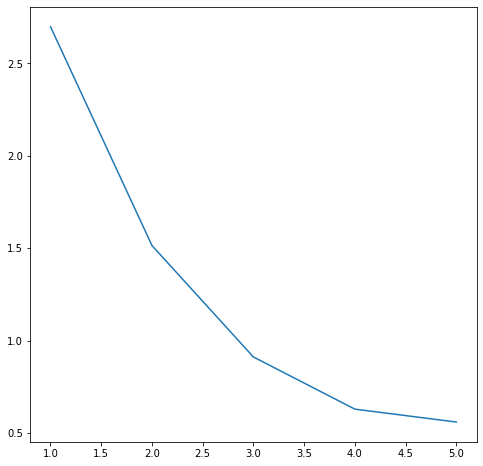

In [227]:
besterrors=np.min(meanerrors,0);
fig, plt.figure(figsize=(8,8))
plt.plot(range(1,6), besterrors);

The elbow converges at k = 4, so let's run k-means with that value.

In [35]:
centroids, clusters, meanerror=kmeans(result[['College', 'Response %', '# Enrolled']], k=4)

Let's plot the data using the clusters, and in 3 dimensions this time!

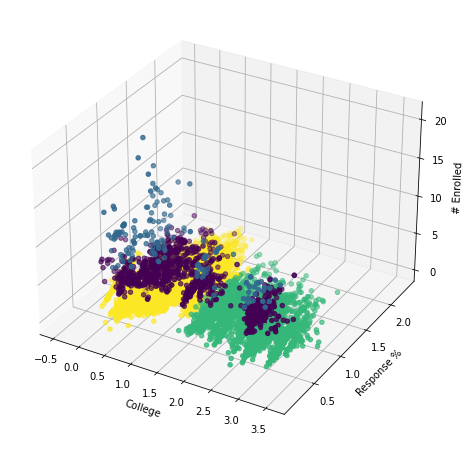

In [37]:
fig, plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter(result['College'], result['Response %'], result['# Enrolled'], c=clusters);
ax.set_xlabel('College');
ax.set_ylabel('Response %');
ax.set_zlabel('# Enrolled');

We can now see where all of our classes lie visually. We can also determine which cluster each class exists in by checking the clusters list, so we'll use that to gather a list of neighbors for a given class and determine which other classes are the closest, or most similar. Let's choose this class, Advanced Data Science, as the class and Zach Mullen as the instructor. We'll exit the check once we find the first instance of this class/instructor combo, which occurs most recently in the Spring 2021 semester.

In [208]:
input_class = 'Advanced Data Science'
input_instructor = 'Mullen, Zachary'

In [216]:
class_num = float(title_nums[input_class])
instructor_num = float(instructor_nums[input_instructor])
for i, row in unnormalized_classes.iterrows():
    if row.Class == class_num and row.Instructor == instructor_num:
        break

cluster = clusters[i]
nbrs = []

loc = (i, [result['College'][i], result['Response %'][i], result['# Enrolled'][i]])

for i, row in unnormalized_classes.iterrows():
    if clusters[i] == cluster:
        nbrs.append((i, [result['College'][i], result['Response %'][i], result['# Enrolled'][i]]))

Now we find the closest neighbor by computing the smallest norm of the two locations.

In [223]:
dist = np.inf
for nbr in nbrs:
    if np.linalg.norm(np.subtract(loc[1], nbr[1])) < dist and loc != nbr:
        nearest = nbr
        dist = np.linalg.norm(np.subtract(loc[1], nbr[1]))

nearest_class = list(title_nums.keys())[list(title_nums.values()).index(unnormalized_classes.Class[nearest[0]])]
nearest_class_instructor = list(instructor_nums.keys())[list(instructor_nums.values()).index(unnormalized_classes.Instructor[nearest[0]])]
print(f"The nearest neighbor to {input_class} taught by {input_instructor} is {nearest_class} taught by {nearest_class_instructor} with a distance of {dist:.3f}")

The nearest neighbor to Advanced Data Science taught by Mullen, Zachary is Thermodynamics 2 taught by Walker, Michael Edward with a distance of 0.010


There we have it! If you liked Advanced Data Science and wanted to take a class similar by college, number of students, and response percentage of students, you should take Thermodynamics 2. Obviously, the model doesn't take things like prerequisites into account, so this would have to be part of the input in a larger recommendation system. Let's compute the next two closest neighbors.

In [226]:
dists = [np.inf] * 3
nearest_nbrs = [(0, 0)] * 3
for nbr in nbrs:
    for i, dist in enumerate(dists):
        if np.linalg.norm(np.subtract(loc[1], nbr[1])) < dist and loc != nbr and nbr not in nearest_nbrs:
            nearest_nbrs[i] = nbr
            dists[i] = np.linalg.norm(np.subtract(loc[1], nbr[1]))

for i, nearest_nbr in enumerate(nearest_nbrs):
    dist = np.linalg.norm(np.subtract(loc[1], nearest_nbr[1]))
    nearest_class = list(title_nums.keys())[list(title_nums.values()).index(unnormalized_classes.Class[nearest_nbr[0]])]
    nearest_class_instructor = list(instructor_nums.keys())[list(instructor_nums.values()).index(unnormalized_classes.Instructor[nearest_nbr[0]])]
    print(f"Nearest neighbor #{i+1} {input_class} taught by {input_instructor} is {nearest_class} taught by {nearest_class_instructor} with a distance of {dist:.3f}")

Nearest neighbor #1 Advanced Data Science taught by Mullen, Zachary is Thermodynamics 2 taught by Walker, Michael Edward with a distance of 0.010
Nearest neighbor #2 Advanced Data Science taught by Mullen, Zachary is Hydraulic Engineering taught by Neupauer, Roseanna Marie with a distance of 0.089
Nearest neighbor #3 Advanced Data Science taught by Mullen, Zachary is Component Design taught by Reamon, Derek T with a distance of 0.178
